In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.__version__

'1.9.0'

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


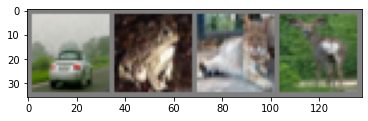

  car  frog   cat  deer


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

C:\Users\wkdcl\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 2.270
[1,  4000] loss: 1.907
[1,  6000] loss: 1.706
[1,  8000] loss: 1.591
[1, 10000] loss: 1.505
[1, 12000] loss: 1.447
[2,  2000] loss: 1.372
[2,  4000] loss: 1.364
[2,  6000] loss: 1.306
[2,  8000] loss: 1.277
[2, 10000] loss: 1.276
[2, 12000] loss: 1.257
Finished Training


In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

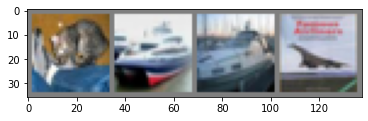

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 54.0 %
Accuracy for class car   is: 48.6 %
Accuracy for class bird  is: 40.8 %
Accuracy for class cat   is: 28.4 %
Accuracy for class deer  is: 47.6 %
Accuracy for class dog   is: 51.4 %
Accuracy for class frog  is: 76.4 %
Accuracy for class horse is: 60.6 %
Accuracy for class ship  is: 77.4 %
Accuracy for class truck is: 73.6 %


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [17]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [20]:
inputs, labels = data[0].to(device), data[1].to(device)

# 2

In [24]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
densenet = models.densenet161(pretrained=True)
inception = models.inception_v3(pretrained=True)
googlenet = models.googlenet(pretrained=True)
shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
mnasnet = models.mnasnet1_0(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\wkdcl/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to C:\Users\wkdcl/.cache\torch\hub\checkpoints\squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to C:\Users\wkdcl/.cache\torch\hub\checkpoints\densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\wkdcl/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\wkdcl/.cache\torch\hub\checkpoints\googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to C:\Users\wkdcl/.cache\torch\hub\checkpoints\shufflenetv2_x1-5666bf0f80.pth


  0%|          | 0.00/8.79M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\wkdcl/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to C:\Users\wkdcl/.cache\torch\hub\checkpoints\mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\wkdcl/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to C:\Users\wkdcl/.cache\torch\hub\checkpoints\resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to C:\Users\wkdcl/.cache\torch\hub\checkpoints\wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/mnasnet1.0_top1_73.512-f206786ef8.pth" to C:\Users\wkdcl/.cache\torch\hub\checkpoints\mnasnet1.0_top1_73.512-f206786ef8.pth


  0%|          | 0.00/16.9M [00:00<?, ?B/s]

In [39]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [41]:
import torch
from torchvision import datasets, transforms as T

transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])
dataset = datasets.ImageNet("", split="train", transform=transform)

means = []
stds = []
for img in subset(dataset):
    means.append(torch.mean(img))
    stds.append(torch.std(img))

mean = torch.mean(torch.tensor(means))
std = torch.mean(torch.tensor(stds))

RuntimeError: The archive ILSVRC2012_devkit_t12.tar.gz is not present in the root directory or is corrupted. You need to download it externally and place it in .

# 3

In [42]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [44]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

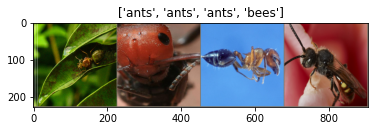

In [45]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [46]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [47]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [48]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [49]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5203 Acc: 0.7213
val Loss: 0.2029 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.5376 Acc: 0.7787
val Loss: 0.4316 Acc: 0.8105

Epoch 2/24
----------
train Loss: 0.5209 Acc: 0.7541
val Loss: 0.5609 Acc: 0.7778

Epoch 3/24
----------
train Loss: 0.5137 Acc: 0.7787
val Loss: 0.4922 Acc: 0.7974

Epoch 4/24
----------
train Loss: 0.4733 Acc: 0.7828
val Loss: 0.3542 Acc: 0.8562

Epoch 5/24
----------
train Loss: 0.4913 Acc: 0.8197
val Loss: 0.2353 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4318 Acc: 0.8279
val Loss: 0.2692 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3902 Acc: 0.8361
val Loss: 0.2112 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3176 Acc: 0.8648
val Loss: 0.2315 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3597 Acc: 0.8361
val Loss: 0.1787 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2938 Acc: 0.8689
val Loss: 0.1877 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3012 Acc: 0.8648
val Loss: 0.1927 Acc: 0.9150

Ep

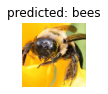

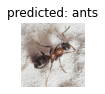

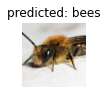

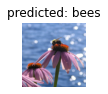

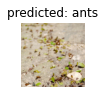

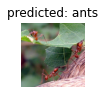

In [50]:
visualize_model(model_ft)

In [51]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [52]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6019 Acc: 0.6557
val Loss: 0.2196 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5658 Acc: 0.7254
val Loss: 0.2076 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4468 Acc: 0.8033
val Loss: 0.2763 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4463 Acc: 0.7992
val Loss: 0.2894 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.4854 Acc: 0.7869
val Loss: 0.1831 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3084 Acc: 0.8484
val Loss: 0.1719 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3973 Acc: 0.8402
val Loss: 0.1737 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3583 Acc: 0.8279
val Loss: 0.2066 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3152 Acc: 0.8525
val Loss: 0.1692 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3831 Acc: 0.8197
val Loss: 0.1740 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3223 Acc: 0.8361
val Loss: 0.1859 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3384 Acc: 0.8525
val Loss: 0.1751 Acc: 0.9412

Ep

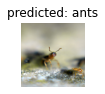

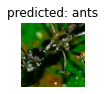

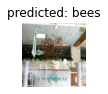

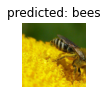

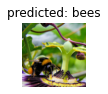

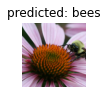

In [53]:
visualize_model(model_conv)

plt.ioff()
plt.show()